## Simulating the spin model:

In [1]:
from ising_utils import *

In [2]:
def local_field(model, i):
    """Compute the local field at spin i"""
    total_neighbors = np.sum(model.connection_matrix[i] * model.spins)
    magnetization = np.sum(model.spins) / len(model.spins)
    return model.J * total_neighbors - model.alpha * model.spins[i] * magnetization

Running simulation with 1024 spins, J=1, alpha=4, T=1.5, steps=1000
Step 0/1000
Step 100/1000
Step 200/1000
Step 300/1000
Step 400/1000
Step 500/1000
Step 600/1000
Step 700/1000
Step 800/1000
Step 900/1000
Simulation finished


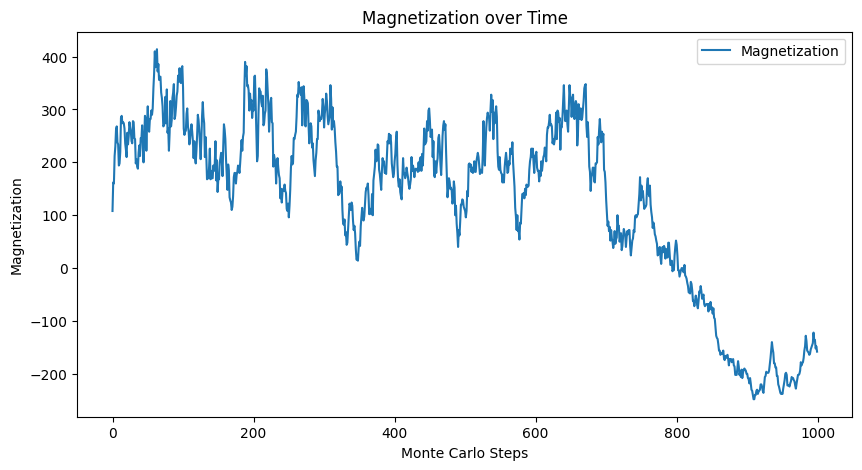

interactive(children=(IntSlider(value=0, description='t', max=999), Output()), _dom_classes=('widget-interact'…

In [3]:
# Running the simulation
model = LatticeSpinMarketModel(side=32, dim=2, J=1, alpha=4, T=1.5, steps=1000, local_field_func=local_field)
spin_series = model.run_simulation(verbose=True)
model.plot_magnetization(spin_series)
model.plot_lattice(spin_series=spin_series, interactive=True)

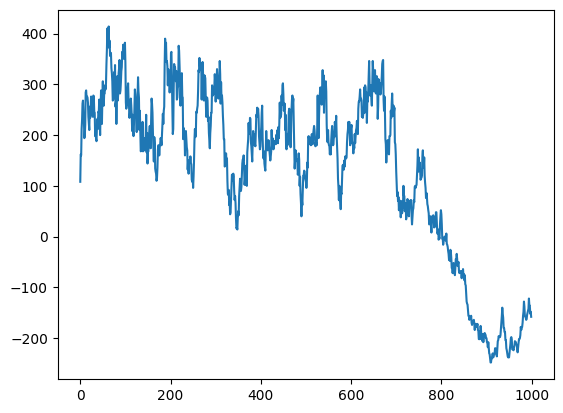

In [5]:
magnetization_series = [np.sum(spin) for spin in spin_series]

plt.plot(magnetization_series)